In [63]:
from sklearn.preprocessing import StandardScaler
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import os
import warnings
import sklearn
import time 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


#preparation des données
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#mesure performance : 
from sklearn import metrics
warnings.filterwarnings("ignore")

### Récupération des données train : 

In [64]:
path = r'D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\dataset\train.csv'
data = pd.read_csv(path)
df = data.copy()

### Récupération des données test:

In [65]:
path_test = r'D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\dataset\test.csv'
data_test = pd.read_csv(path_test)
test = data_test.copy()

## Preprocessing effectué sur le fichier train.csv :

In [66]:
var_num = []
var_dis, var_cont = [],[]
var_qual = []
var_cat = []
var_tot = df.columns

In [67]:
#Récupération des variables pouvant prendre au maximum 6 valeurs : 
var_dis = [i for i in df if df[i].nunique()<=6]
#Récupération des variables continues par exclusion des variables discrètes :
#Rq : on exclu l'id des individus car il n'a que pour rôle de différencier chq individus
var_cont = [i for i in df if i not in var_dis and i != "id"]

In [68]:
#Convertissons les variables continues en float :
df[var_cont] = df[var_cont].astype(float)

In [69]:
#Séparation des données
X,y = df.drop("smoking", axis = 1), df.smoking
var_dis = [i for i in var_dis if i!= y.name]

X_train, X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2 )

#Standardisation
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[var_cont]), 
                              index= X_train.index, columns=X[var_cont].columns)

#Transformation : 
X_test_scaled = pd.DataFrame(scaler.transform(X_test[var_cont]), 
                             index=X_test.index, columns=X[var_cont].columns)
#Concaténation de la partie train et test :
X_scaled = pd.concat([X_train_scaled, X_test_scaled])

In [70]:
#Concaténation des features X contenant les variables discrètes : 
X_dis = pd.concat([X_train[var_dis], X_test[var_dis]], axis = 0) 

#Fusion des features disrètes et continues après normalisation :
new_df_withoutPCA = pd.concat([X_scaled, X_dis], axis= 1) #concaténation des features continues et discrètes
new_df_withoutPCA.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,hearing(left),hearing(right),Urine protein,dental caries
60700,-0.363764,-1.729695,-1.361653,-0.333247,-1.261648,-1.278404,-0.194342,0.127119,0.239934,-0.591152,...,-0.197121,-2.090771,-1.626365,-1.190789,-0.851755,-0.871202,1,1,1,0
44065,1.750195,-1.729695,-1.361653,-1.563035,-0.762843,-0.002432,1.298727,1.348476,9.462864,0.500179,...,0.258438,1.052672,-1.626365,-0.880976,-0.139049,-0.358082,1,1,1,0
39538,0.904612,-1.162983,-0.963707,-0.333247,0.484171,0.507957,-1.058751,-0.650109,-0.610407,-1.471258,...,-0.652681,-0.973102,-1.626365,-0.674434,-0.632461,-0.646712,1,1,1,0
105427,0.904612,-0.596270,-0.565762,0.002149,-0.762843,-0.512820,0.591484,0.349184,-0.610407,1.204263,...,1.555031,-0.134851,-1.071018,-1.190789,-0.742108,-0.326012,1,1,1,0
148669,-1.209348,1.670580,1.821910,1.343736,-0.014635,0.507957,-0.194342,0.571249,-0.741229,-1.154420,...,-1.003112,-0.693685,0.039675,-0.054807,0.189892,-0.486362,1,1,1,0


## Application du même prétraitement pour le fichier test.csv : 

In [74]:
test_scaled = test.copy()
test_scaled.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


pour le fichier test.csv, il faudra simplement standardiser les données, pas besoin d'encodage.

In [75]:
test_scaled[var_cont] = pd.DataFrame(scaler.transform(test_scaled[var_cont]), columns=test_scaled[var_cont].columns)
test_scaled.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,-0.363764,-0.029558,0.230129,0.113948,0.484171,0.507957,1,1,0.591484,...,0.882661,-0.491451,0.013137,-0.414268,1,0.039675,-0.674434,-0.084226,-0.133593,0
1,159257,3.018571,-0.596270,-0.565762,1.120138,-0.014635,-0.002432,2,2,1.691640,...,0.459826,-1.493887,-0.372337,-1.252519,1,1.150368,-0.571163,-0.796932,-0.390152,0
2,159258,1.327404,0.537155,0.230129,0.393445,-1.012246,-0.768015,1,1,-0.430090,...,0.686345,-1.207477,-0.933026,0.423984,1,2.816408,1.287717,1.834598,-0.005313,0
3,159259,-0.363764,-0.596270,-1.361653,-1.786632,-1.760454,-1.533598,1,1,-0.508673,...,-1.216413,1.370216,0.468697,-0.204705,1,-1.626365,-0.054807,-0.467990,-0.839132,1
4,159260,-0.363764,0.537155,0.628074,0.717662,-0.014635,-0.257626,1,1,0.748649,...,-0.416047,-1.207477,0.293481,1.192381,1,0.595022,0.461548,0.683304,-0.293942,1


Les données ont été standardisées, maintenant nous allons les mettre dans le même ordre que le fichier train.csv :
- Pour cela, comme **l'id** n'a pas été conservé dans le fichier **train.csv**, lorsqu'on va appeler les colonnes de new_df_withoutPCA, la colonne id ne sera pas appelée, par conséquent, il nous suffira simplement de concaténer la colonne id initialement présente dans le fichier test.csv pour les retrouver :

In [85]:
test_preprocessed = pd.concat([test_scaled.id, test_scaled[new_df_withoutPCA.columns]], axis = 1) #test.id 
#fournirait les id dans le meme ordre aussi

In [97]:
test_preprocessed.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,...,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,hearing(left),hearing(right),Urine protein,dental caries
0,159256,-0.363764,-0.029558,0.230129,0.113948,0.484171,0.507957,0.591484,1.348476,0.566988,...,0.013137,-0.414268,0.039675,-0.674434,-0.084226,-0.133593,1,1,1,0
1,159257,3.018571,-0.596270,-0.565762,1.120138,-0.014635,-0.002432,1.691640,-0.539076,-0.348764,...,-0.372337,-1.252519,1.150368,-0.571163,-0.796932,-0.390152,2,2,1,0
2,159258,1.327404,0.537155,0.230129,0.393445,-1.012246,-0.768015,-0.430090,-0.205979,-0.414175,...,-0.933026,0.423984,2.816408,1.287717,1.834598,-0.005313,1,1,1,0
3,159259,-0.363764,-0.596270,-1.361653,-1.786632,-1.760454,-1.533598,-0.508673,-1.649402,-0.479586,...,0.468697,-0.204705,-1.626365,-0.054807,-0.467990,-0.839132,1,1,1,1
4,159260,-0.363764,0.537155,0.628074,0.717662,-0.014635,-0.257626,0.748649,1.903639,-1.264516,...,0.293481,1.192381,0.595022,0.461548,0.683304,-0.293942,1,1,1,1


### Enregistrement du fichier test apres preprocessing : 

In [87]:
os.getcwd()

'D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\notebook'

In [93]:
save_path = 'D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\dataset\\'

In [94]:
test_preprocessed.to_csv(save_path+ "test_preprocessed.csv")

## Chargement du modèle préentrainé pour les prédictions : 

In [111]:
path_loaded_model = r"D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\Modeles_withoutPCA"

In [116]:
os.listdir(path_loaded_model)

['DummyClassifier.pkl',
 'Grid',
 'KNeighborsClassifier.pkl',
 'LogisticRegression.pkl',
 'RandomForestClassifier.pkl',
 'SGDClassifier.pkl']

In [120]:
loaded_model = pickle.load(open(path_loaded_model+"\RandomForestClassifier.pkl", 'rb'))
loaded_model

RandomForestClassifier()

### Application du modèle :

In [113]:
X_test = test_preprocessed.drop("id", axis = 1)

In [128]:
y_pred = loaded_model.predict_proba(X_test)
y_pred

array([[0.29, 0.71],
       [0.61, 0.39],
       [0.42, 0.58],
       ...,
       [0.62, 0.38],
       [0.88, 0.12],
       [0.99, 0.01]])

#### Attention : 
- Kaggle nous demande de soumettre les données de la façon suivante :

#### Submission File
For each id in the test set, you must predict the probability for the target variable smoking. The file should contain a header and have the following format:

id,smoking

159256,0.5

159257,0.5

159258,0.5

...

Autrement dit, il faut récupérer uniquement la probabilité que l'individue sois fumeur (la 2ème colonne) 

In [137]:
smoking_df = pd.DataFrame(y_pred[:,1], columns=["smoking"])

### Création du dataframe final pour kaggle :

In [140]:
predicted_data = pd.concat([test_preprocessed.id, smoking_df], axis = 1)

In [139]:
predicted_data

,id,smoking
0,159256,0.71
1,159257,0.39
2,159258,0.58
3,159259,0.00
4,159260,0.53
...,...,...
106166,265422,0.43
106167,265423,0.56
106168,265424,0.38
106169,265425,0.12


#### Enregistrement et soumission sur kaggle

In [145]:
save = 'D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\dataset'

In [152]:
predicted_data.to_csv(save_path+ "predicted_data.csv", index = False)

In [153]:
#Verifions que le jeu de données est enregistré correctement :
pd.read_csv(save_path+"predicted_data.csv")

,id,smoking
0,159256,0.71
1,159257,0.39
2,159258,0.58
3,159259,0.00
4,159260,0.53
...,...,...
106166,265422,0.43
106167,265423,0.56
106168,265424,0.38
106169,265425,0.12


Nous pouvons soumettre le csv sur https://www.kaggle.com/competitions/playground-series-s3e24/submissions

## Résultats obtenue : 


In [160]:
from IPython.display import Image

In [182]:
submission_path = "D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\resultats.jpg"

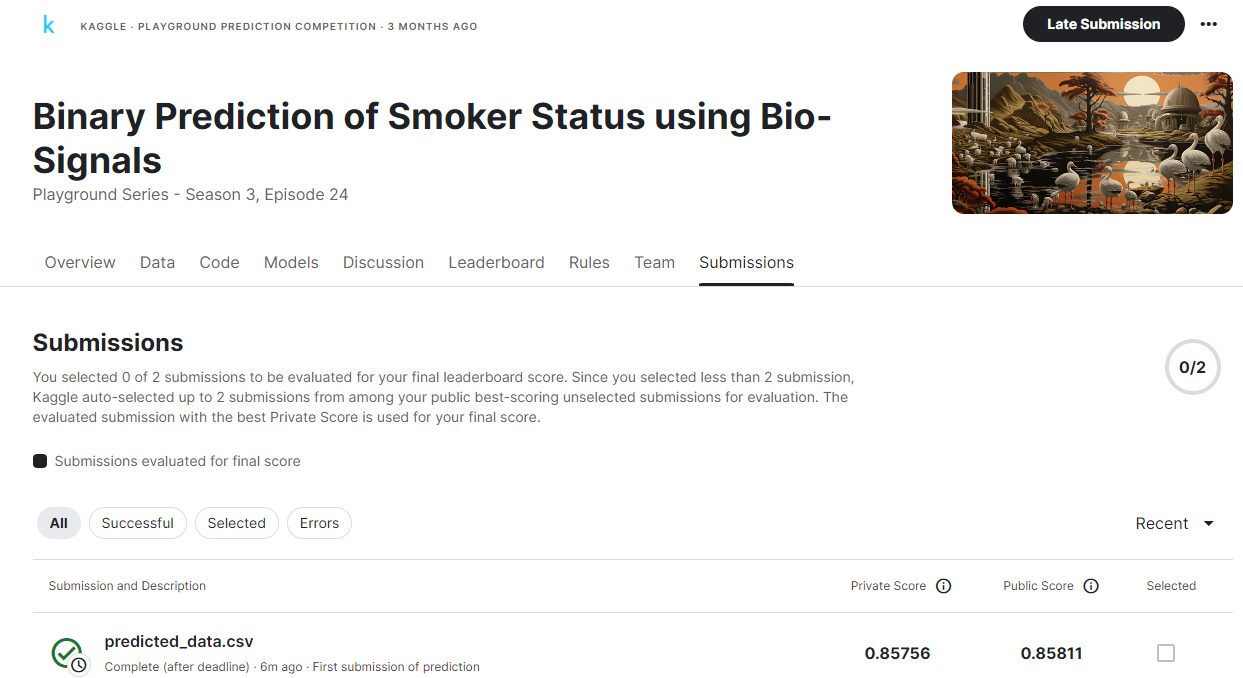

In [186]:
Image(submission_path)

Nous avons obtenu 85%, le meilleur score est de 87%, nous avons donc eu un score plutôt correct.